# Bioimage Analysis Workflow 2 - Seed Clustering (2)

## Import data and necessary packages

In [1]:
from skimage.io import imread

import matplotlib.pyplot as plt

import numpy as np

import scipy.ndimage as ndi

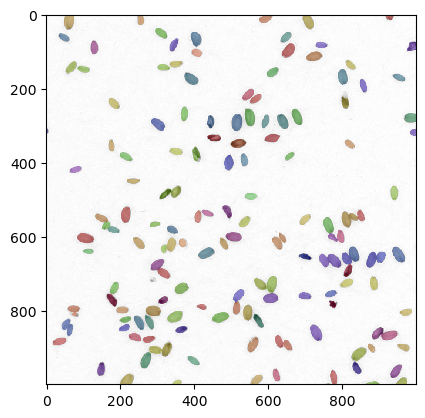

In [2]:
# Define path
labels_filepath = r'example_data/seed_labels.tif'
img_filepath = r'example_data/seed_img_1.JPG'

# Read images
seed_rois = imread(labels_filepath)
img = imread(img_filepath)

# Split channel
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

# Define a range to visulize
x_start = 1000
x_end = 2000
y_start = 1000
y_end = 2000

# Display label on top of the image
seeds_seed_rois_mask = np.ma.array(seed_rois, mask=seed_rois==0)
plt.imshow(img_ch1[y_start: y_end, x_start: x_end], interpolation='none', cmap='gray')
plt.imshow(seeds_seed_rois_mask[y_start: y_end, x_start: x_end], interpolation='none', cmap='prism', alpha = 0.3)

## Measure Properties of Seeds

In [3]:
from skimage.measure import regionprops_table

props_ch0 = regionprops_table(seed_rois, img_ch0, properties=['area', 
                                                              'intensity_mean',
                                                              'intensity_min',
                                                              'eccentricity',
                                                              'feret_diameter_max',
                                                              'perimeter',
                                                              'solidity',
                                                             ])
props_ch1 = regionprops_table(seed_rois, img_ch1, properties=['intensity_mean'])

In [4]:
import pandas as pd

In [5]:
props_ch0_df = pd.DataFrame(props_ch0)
props_ch1_df = pd.DataFrame(props_ch1)

In [6]:
props_df = props_ch0_df.join(props_ch1_df, lsuffix='_ch0', rsuffix='_ch1')

In [7]:
props_df.head()

,area,intensity_mean_ch0,intensity_min,eccentricity,feret_diameter_max,perimeter,solidity,intensity_mean_ch1
0,398,226.500000,201.0,0.883602,32.802439,81.254834,0.947619,200.881910
1,299,224.076923,201.0,0.838284,26.076810,66.426407,0.964516,192.421405
2,742,211.196765,179.0,0.793202,40.261644,105.254834,0.966146,178.359838
3,385,227.600000,200.0,0.872333,32.202484,77.597980,0.960100,195.579221
4,745,214.987919,182.0,0.803746,41.436699,105.740115,0.967532,181.785235


Text(0, 0.5, 'ch1 Intensity')

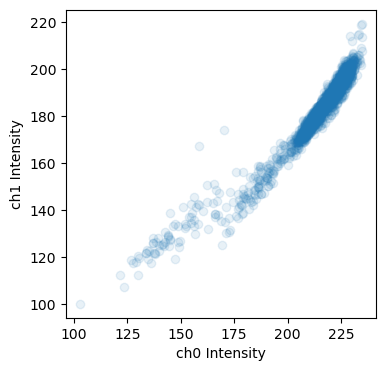

In [8]:
# Visulize the distribution of data points in color space

plt.figure(figsize=(4,4))
plt.plot(props_df['intensity_mean_ch0'], props_df['intensity_mean_ch1'], 'o', alpha=0.1)
plt.xlabel('ch0 Intensity')
plt.ylabel('ch1 Intensity')

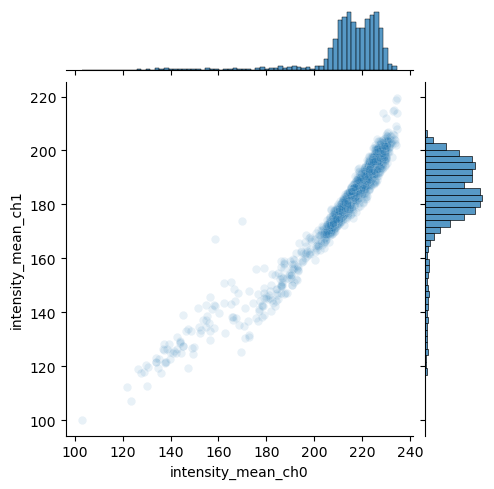

In [9]:
# You can also use the seaborn library, a higher level library that utilize pandas and matplotlib to plot graphs

# “Seaborn is a library for making statistical graphics in Python. It builds on top of matplotlib and integrates 
# closely with pandas data structures.”

import seaborn as sns
sns.jointplot(data=props_df, x="intensity_mean_ch0", y="intensity_mean_ch1",alpha=0.1, height=5)

But we are also interested in looking at the distribution of data points in other dimensions. We can use other features of a scatter plot to represent other aspects of the data

<Axes: xlabel='intensity_mean_ch0', ylabel='intensity_mean_ch1'>

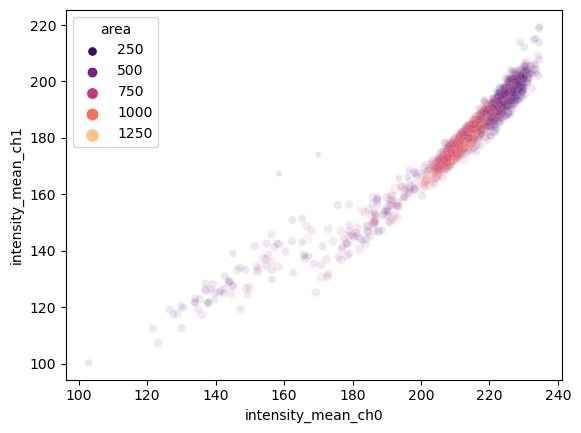

In [10]:
sns.scatterplot(data=props_df, x="intensity_mean_ch0", y="intensity_mean_ch1", size="area", hue="area", palette='magma', alpha = 0.1)

Next, we will look into the dimensional reduction technique to visulize high dimensional data

# Dimensional Reduction

## PCA

In [11]:
# Data scaling
props_data = props_df.values

In [12]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
props_data_scaled = std_scaler.fit_transform(props_data)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
seed_pca = pca.fit(props_data_scaled).transform(props_data_scaled)

In [14]:
print(pca.components_)

[[ 0.4142977  -0.37310657 -0.39521641 -0.11548818  0.41551002  0.4242362
  -0.01147771 -0.40848342]
 [-0.40322529 -0.45077386 -0.40409955  0.08881133 -0.370682   -0.37869061
  -0.1560221  -0.39733334]]


In [15]:
print(
    "explained variance ratio: %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio: [0.43663458 0.29665156]


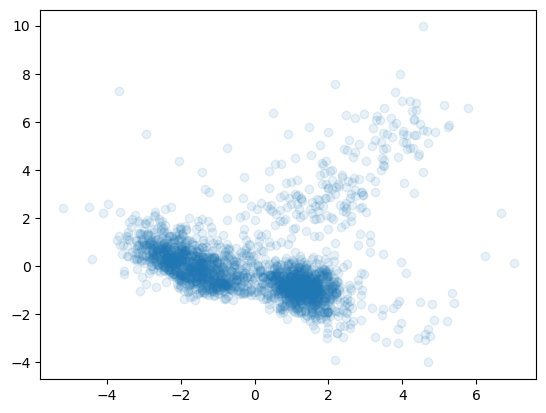

In [16]:
plt.scatter(seed_pca[:, 0], seed_pca[:, 1],alpha = 0.1)

## UMAP

How UMAP works: https://umap-learn.readthedocs.io/en/latest/how_umap_works.html

In [17]:
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

C:\Users\OWNER\anaconda3\envs\bioimage-analysis4\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\OWNER\anaconda3\envs\bioimage-analysis4\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\OWNER\anaconda3\envs\bioimage-analysis4\lib\site-packag

In [18]:
np.random.seed(60)

In [19]:
reducer = umap.UMAP()

In [20]:
embedding = reducer.fit_transform(props_data_scaled)

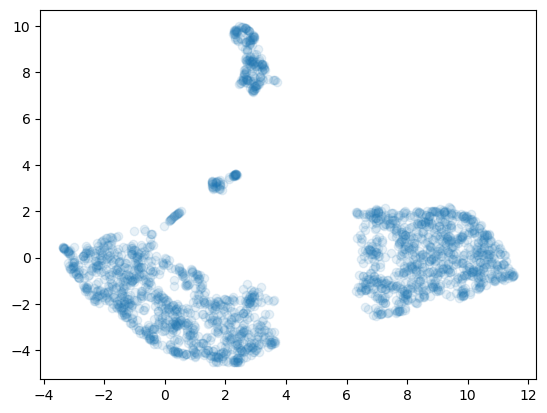

In [21]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha = 0.1)

Next, lets apply the clustering method to classify points to each groups.

# Clustering

## k-mean analysis

In [22]:
from sklearn.cluster import KMeans

In [23]:
n_clusters = 4
kmeans = KMeans(n_clusters= n_clusters, random_state=42).fit(embedding)

In [24]:
kmeans_prediction = kmeans.predict(embedding)

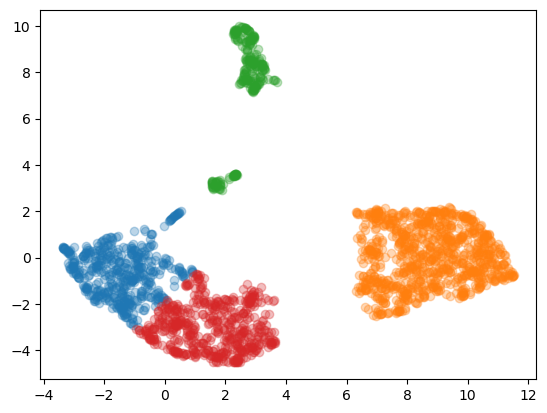

In [25]:
for i in range(n_clusters):
    plt.plot(embedding[:, 0][kmeans_prediction == i], embedding[:, 1][kmeans_prediction == i], 'o', alpha = 0.3)

## HDBSCAN

How HDBSCAN works: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [26]:
import hdbscan

In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(embedding)

HDBSCAN(min_cluster_size=15)

In [28]:
cluster_ids = np.unique(clusterer.labels_)
print(f'There are {len(cluster_ids)} clusters, with cluster ID: {cluster_ids}.')

There are 7 clusters, with cluster ID: [-1  0  1  2  3  4  5].


Text(0.5, 1.0, 'UMAP Analysis Results, labelled by HDBSCAN cluster ID')

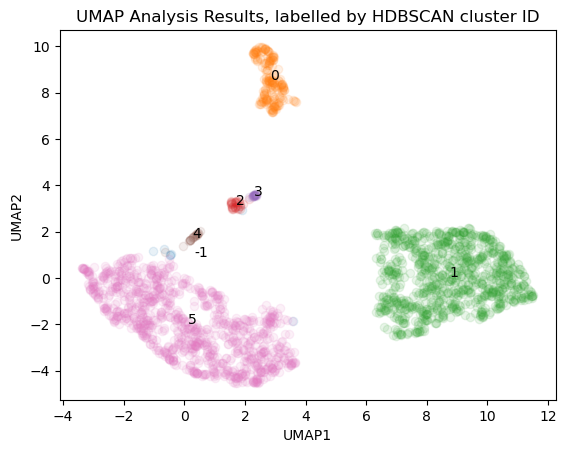

In [29]:
for cluster_id in cluster_ids:
    x = embedding[:, 0][clusterer.labels_ == cluster_id]
    y = embedding[:, 1][clusterer.labels_ == cluster_id]
    plt.scatter(x, y, alpha = 0.1)
    plt.text(np.mean(x), np.mean(y),str(cluster_id))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Analysis Results, labelled by HDBSCAN cluster ID')

# Visulize the classified results on the image

In [30]:
props_df.shape[0]

2232

In [31]:
# Check the original image for the clustering result
num_roi = props_df.shape[0]

roi_cluster_labels = np.zeros_like(seed_rois)

for roi_id in range(num_roi):

    if roi_id%100 == 0:
        print(f'Processing seed #{roi_id}')

    # Get ROI of a single seed
    seed_roi = seed_rois == roi_id + 1

    # Add ROIs to the roi_cluster_labels, with label as cluster Id + 1 (+1 such that the label won't be background)
    roi_cluster_labels[seed_roi] = clusterer.labels_[roi_id] + 5

Processing seed #0
Processing seed #100
Processing seed #200
Processing seed #300
Processing seed #400
Processing seed #500
Processing seed #600
Processing seed #700
Processing seed #800
Processing seed #900
Processing seed #1000
Processing seed #1100
Processing seed #1200
Processing seed #1300
Processing seed #1400
Processing seed #1500
Processing seed #1600
Processing seed #1700
Processing seed #1800
Processing seed #1900
Processing seed #2000
Processing seed #2100
Processing seed #2200


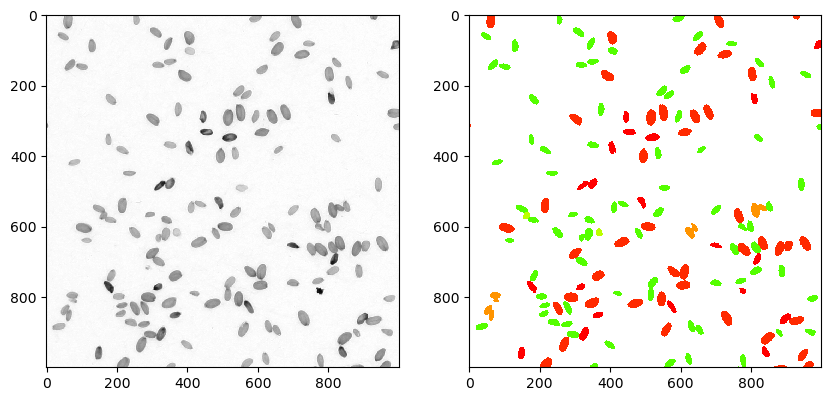

In [34]:
roi_cluster_labels_mask = np.ma.array(roi_cluster_labels, mask=roi_cluster_labels==0)
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img_ch1[y_start: y_end, x_start: x_end], interpolation='none', cmap='gray')
plt.subplot(122)
plt.imshow(roi_cluster_labels_mask[y_start: y_end, x_start: x_end], interpolation='none', cmap='prism')

In [35]:
# First import module napari
import napari

# Create an empty viewer object
viewer = napari.Viewer()

# Use viewer.add_image() and pass the image as a variable to visulize the image. Similar to that for matplotlib, set options:
#  * colormap as 'gray'
#  * interpolation (interpolation2d) is 'nearest' (which correspond to minimum interpolation) by default, so no need to specify 
#  * name as 'Raw Image'
viewer.add_image(img_ch0, colormap = 'red', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch1, colormap = 'green', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch2, colormap = 'blue', name= 'Raw Image', blending= 'additive')

viewer.add_labels(roi_cluster_labels)

<Labels layer 'roi_cluster_labels' at 0x2268675c700>

In [ ]:
viewer.add_labels(seed_rois)

## Compare the color distribution

In [ ]:
# Add the cluster labels to the props_df
props_df.insert(0, "Cluster ID", clusterer.labels_)

In [ ]:
props_df.head()

In [ ]:
sns.kdeplot(data=props_df, x="intensity_mean_ch0", hue="Cluster ID")

In [ ]:
sns.kdeplot(data=props_df, x="area", hue="Cluster ID")